## The Environment

There are three players, and one cookie (a circle of radius $1$).

In a single rollout:
1. The first player makes a fixed cut at $0$ radians.
2. The second player makes a cut at $\theta_2 \in [- \pi, \pi]$.
3. The third player makes a cut at $\theta_3 \in [- \pi, \pi]$
4. In order, each player greedily picks pieces of the cookie.
5. Each player's reward is the area of their slice at the end of the rollout: player 2 is trying act so as to maximize the size of the second smallest slice and player three the size of the smallest.



## Hacking Stable Baselines to Do Multi-Agent


`stablebaslines3` really only does single agent training, but we need to train two separate policies with their own rewards. I hacked around this by alternating training between each one. When one is training, the other is fixed, then swap after a certain number of steps.

In [13]:

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np


class TwoPlayerCakeCuttingEnv(gym.Env):
    """
    Two-player cake cutting with self-play:
    - Player 0: Always cuts at 0 (with small noise)
    - Player 1: Cuts at some angle 
    - Player 2: Cuts at some angle 
    - Players pick in order 0, 1, 2 (but player 0 always gets same expected value)
    
    Alternates training player 1 and player 2.
    """
    
    def __init__(self, policy=None, fixed_angle=0.0, noise_std=0.1):
        super().__init__()
        
        self.n_players = 3
        self.radius = 1.0
        self.policy = policy
        self.fixed_angle = fixed_angle
        self.noise_std = noise_std

        
        # Action space is a single float from [-pi, pi]
        # Symmetric for ease of learning
        self.action_space = spaces.Box(
            low=-np.pi, 
            high=np.pi, 
            shape=(1,), 
            dtype=np.float32
        )

        # Observation space is three floats plus one-hot encoded player IDs.
        # The 
        self.observation_space = spaces.Box(
            low=-np.pi,
            high=np.pi,
            shape=(self.n_players + self.n_players,),
            dtype=np.float32
        )
        
        self.episode_count = 0
        self.current_training_player = 1  # Only train players 1 and 2
        
        self.reset()
    
    def set_policy(self, policy):
        """Called by the training callback to update the policy."""
        self.policy = policy
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        # Alternate between training player 1 and player 2
        # Player 0 is always deterministic
        self.current_training_player = 1 + (self.episode_count % 2)
        self.episode_count += 1
        
        self.angles = []
        self.current_player = 0
        self.done = False
        
        return self._get_obs(), {}
    
    def _get_obs(self):
        angles_padded = self.angles + [0.0] * (self.n_players - len(self.angles))
        
        player_one_hot = [0.0] * self.n_players
        if not self.done:
            player_one_hot[self.current_player] = 1.0
        
        obs = np.array(angles_padded + player_one_hot, dtype=np.float32)
        return obs
    
    def _compute_wedge_areas(self):
        """Given the angles of three cuts, compute the areas of each wedge
        """
        # Reparametrize to [0, 2*pi] radians format
        sorted_angles = sorted([(angle + np.pi) % (2 * np.pi) for angle in self.angles])
        
        wedge_angles = []
        for i in range(len(sorted_angles)):
            next_angle = sorted_angles[(i + 1) % len(sorted_angles)]
            angle_diff = (next_angle - sorted_angles[i]) % (2 * np.pi)
            wedge_angles.append(angle_diff)
        
        wedge_areas = [angle / 2.0 for angle in wedge_angles]
        
        return sorted(wedge_areas, reverse=True)
    
    def _greedy_assignment(self, wedge_areas):
        """Greedily assigns pieces to each player, in order.
        """
        player_areas = [0.0] * self.n_players
        
        for player in range(min(self.n_players, len(wedge_areas))):
            player_areas[player] = wedge_areas[player]
        
        return player_areas
    
    def step(self, action):
        if self.done:
            raise RuntimeError("Episode is done, call reset()")
        
        # Determine the action for current player
        if self.current_player == 0:
            # Player 0: Always cuts at fixed_angle with small noise
            noise = np.random.normal(0, self.noise_std)
            angle = self.fixed_angle + noise
        elif self.current_player != self.current_training_player:
            # Not training player (1 or 2) - use current policy
            if self.policy is not None:
                obs = self._get_obs()
                action_pred, _ = self.policy.predict(obs, deterministic=False)
                angle = float(action_pred[0])
            else:
                # No policy yet (early training), use random
                angle = self.action_space.sample()[0]
        else:
            # Training player - use provided action
            angle = float(action[0])
        
        self.angles.append(angle)
        current_player = self.current_player
        self.current_player += 1
        
        # Continue until we reach the training player's turn or episode ends
        if self.current_player < self.n_players:
            if self.current_player == self.current_training_player:
                # Training player's turn next - return control
                return self._get_obs(), 0.0, False, False, {}
            else:
                # Not training player's turn - auto-step
                return self.step(self.action_space.sample())  # Dummy action, will be replaced
        
        # Episode is done
        self.done = True
        
        wedge_areas = self._compute_wedge_areas()
        player_areas = self._greedy_assignment(wedge_areas)
        
        # Return reward for the training player
        reward = player_areas[self.current_training_player]
        
        info = {
            'player_areas': player_areas,
            'wedge_areas': wedge_areas,
            'episode_done': True,
            'angles_world_frame': self.angles,
            'training_player': self.current_training_player
        }
        
        return self._get_obs(), reward, True, False, info



class SelfPlayCallback(BaseCallback):
    """Callback that updates the environment's policy pointer."""
    
    def __init__(self, update_freq=2048, verbose=0):
        super().__init__(verbose)
        self.update_freq = update_freq
    
    def _on_step(self) -> bool:
        if self.n_calls % self.update_freq == 0:
            if hasattr(self.training_env, 'env_method'):
                self.training_env.env_method('set_policy', self.model)
            elif hasattr(self.training_env, 'set_policy'):
                self.training_env.set_policy(self.model)
        
        return True



## The Network Architecture

### Angle Encoder

In [14]:
import torch
from torch import nn


class AngleEncoder(nn.Module):
    """Encode angles using random Fourier features for periodicity."""
    
    def __init__(self, encoder_dim: int):
        super().__init__()
        self.register_buffer(
            'frequencies', 
            torch.randn(encoder_dim // 2)
        )
    
    def forward(self, angles):
        """
        Args:
            angles: shape (..., n_angles)
        Returns:
            encoded: shape (..., n_angles * encoder_dim)
        """
        # angles: (..., n_angles), frequencies: (encoder_dim // 2)
        features = angles.unsqueeze(-1) * self.frequencies
        
        # Concatenate cos and sin
        encoded = torch.cat([torch.cos(features), torch.sin(features)], dim=-1)
        
        # Flatten: (..., n_angles, encoder_dim) -> (..., n_angles * encoder_dim)
        return encoded.flatten(start_dim=-2)

### Angle Decoder

In [15]:
class AngleDecoder(nn.Module):

    def __init__(self, feature_dim: int):
        super().__init__()
        self.decoder = nn.Linear(feature_dim, 1)

    def forward(self, tensor):
        return torch.pi * torch.tanh(self.decoder(tensor))


### Two Networks in a Trenchcoat

In [16]:
from typing import Tuple


class MultiAgentNetwork(nn.Module):
    """
    Custom network with separate policy and value networks for each player.
    Each player gets: encoder -> hidden layers -> policy/value heads
    """

    def __init__(
        self,
        n_players: int = 3,
        angle_encoder_dim: int = 32,
        hidden_dim: int = 128
    ):
        super().__init__()

        self.n_players = n_players
        self.latent_dim_pi = 1
        self.latent_dim_vf = 1
        
        # Shared angle encoder
        self.angle_encoder = AngleEncoder(angle_encoder_dim)
        
        # After encoding: n_players angles * encoder_dim + n_players (one-hot)
        encoded_dim = n_players * angle_encoder_dim + n_players
        
        # Separate networks for each player
        self.player_policy_nets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(encoded_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                AngleDecoder(hidden_dim)
            ) for _ in range(n_players)
        ])
        
        self.player_value_nets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(encoded_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                AngleDecoder(hidden_dim)
            ) for _ in range(n_players)
        ])

    def _encode_observations(self, observations: torch.Tensor) -> torch.Tensor:
        """Encode angles and concatenate with player one-hot."""
        angles = observations[:, :self.n_players]
        player_one_hot = observations[:, self.n_players:]
        
        # Encode angles
        encoded_angles = self.angle_encoder(angles)
        
        # Concatenate with player ID
        return torch.cat([encoded_angles, player_one_hot], dim=-1)

    def _route_through_networks(
        self, 
        encoded_input: torch.Tensor, 
        player_one_hot: torch.Tensor,
        network_list: nn.ModuleList
    ) -> torch.Tensor:
        """Route each sample through the appropriate player's network."""
        batch_size = encoded_input.shape[0]
        output_dim = 1
        output = torch.zeros(batch_size, output_dim, device=encoded_input.device)
        
        player_ids = player_one_hot.argmax(dim=1)
        
        for player_id in range(self.n_players):
            player_indices = (player_ids == player_id).nonzero(as_tuple=True)[0]
            
            if len(player_indices) > 0:
                player_inputs = encoded_input[player_indices]
                player_outputs = network_list[player_id](player_inputs)
                output[player_indices] = player_outputs
        
        return output

    def forward(self, observations: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.forward_actor(observations), self.forward_critic(observations)

    def forward_actor(self, observations: torch.Tensor) -> torch.Tensor:
        encoded = self._encode_observations(observations)
        player_one_hot = observations[:, self.n_players:]
        return self._route_through_networks(encoded, player_one_hot, self.player_policy_nets)

    def forward_critic(self, observations: torch.Tensor) -> torch.Tensor:
        encoded = self._encode_observations(observations)
        player_one_hot = observations[:, self.n_players:]
        return self._route_through_networks(encoded, player_one_hot, self.player_value_nets)


### Embedding this Within StableBaselines ActorCritic API

In [17]:
from typing import Callable, Tuple
from gymnasium import spaces
import torch
from torch import nn
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3 import PPO


class MultiAgentActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        lr_schedule: Callable[[float], float],
        **kwargs,
    ):
        self.policy_kwargs = kwargs.get('policy_kwargs')
        super().__init__(
            observation_space,
            action_space,
            lr_schedule
        )

    def _build_mlp_extractor(self) -> None:
        if self.policy_kwargs:
            self.mlp_extractor = MultiAgentNetwork(
                **self.policy_kwargs
            )
        else:
            self.mlp_extractor = MultiAgentNetwork()

## Visualizing the Policies

In [31]:
def visualize_player1_value_function(model, fixed_angle=0.0):
    """
    Visualize Player 1's value function and policy.
    Player 0 is fixed at the given angle.
    Player 1 needs to consider what Player 2 will do in response.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    n_points = 100
    player1_test_angles = np.linspace(-np.pi, np.pi, n_points)
    
    player1_values = []
    player2_responses = []
    final_player1_areas = []
    
    for angle1 in player1_test_angles:
        # Get Player 1's value estimate for choosing this angle
        obs1 = np.array([fixed_angle, 0.0, 0.0, 0.0, 1.0, 0.0], dtype=np.float32)
        obs1_tensor = torch.FloatTensor(obs1).unsqueeze(0)
        
        with torch.no_grad():
            value1 = model.policy.predict_values(obs1_tensor)
        
        # But also compute what actually happens:
        # Player 2 sees Player 0 at fixed_angle and Player 1 at angle1
        obs2 = np.array([fixed_angle, angle1, 0.0, 0.0, 0.0, 1.0], dtype=np.float32)
        obs2_tensor = torch.FloatTensor(obs2).unsqueeze(0)
        
        with torch.no_grad():
            action2, _, _ = model.policy.forward(obs2_tensor, deterministic=True)
        
        angle2 = float(action2[0])
        player2_responses.append(angle2)
        
        # Compute actual outcome
        angles = [fixed_angle, angle1, angle2]
        sorted_angles = sorted([(a + np.pi) % (2 * np.pi) for a in angles])
        
        wedge_angles = []
        for i in range(len(sorted_angles)):
            next_angle = sorted_angles[(i + 1) % len(sorted_angles)]
            angle_diff = (next_angle - sorted_angles[i]) % (2 * np.pi)
            wedge_angles.append(angle_diff)
        
        wedge_areas = sorted([angle / 2.0 for angle in wedge_angles], reverse=True)
        
        # Player 1 picks second
        final_player1_areas.append(wedge_areas[1])
        player1_values.append(float(value1[0]))
    
    # Plot 1: Player 1's actual outcomes vs their value estimates
    ax1_twin = ax1.twinx()
    
    line1 = ax1.plot(player1_test_angles, final_player1_areas, 
                     linewidth=2.5, color='darkblue', label='Actual area (after P2 responds)')
    line2 = ax1_twin.plot(player1_test_angles, player1_values, 
                          linewidth=2.5, color='orange', linestyle='--', 
                          label='Value estimate', alpha=0.8)
    
    ax1.axhline(y=np.pi/3, color='red', linestyle='--', alpha=0.5)
    ax1.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax1.fill_between(player1_test_angles, final_player1_areas, alpha=0.3, color='blue')
    
    ax1.set_xlabel("Player 1's angle choice (radians)", fontsize=14)
    ax1.set_ylabel("Actual area Player 1 receives", fontsize=14, color='darkblue')
    ax1_twin.set_ylabel("Value estimate", fontsize=14, color='orange')
    ax1.set_title(f"Player 1 Value Function\n(Player 0 fixed at {fixed_angle:.2f}, Player 2 responds)", 
                  fontsize=16, weight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(-np.pi, np.pi)
    
    # Add x-axis labels
    ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax1.set_xticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
    ax1.tick_params(axis='y', labelcolor='darkblue')
    ax1_twin.tick_params(axis='y', labelcolor='orange')
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, fontsize=12, loc='lower left')
    
    # Find equilibrium
    obs = np.array([fixed_angle, 0.0, 0.0, 0.0, 1.0, 0.0], dtype=np.float32)
    obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
    with torch.no_grad():
        action1, _, _ = model.policy.forward(obs_tensor, deterministic=True)
        value1_eq = model.policy.predict_values(obs_tensor)
    
    eq_angle1 = float(action1[0])
    
    # Find actual area at equilibrium
    eq_idx = np.argmin(np.abs(player1_test_angles - eq_angle1))
    eq_actual_area = final_player1_areas[eq_idx]
    

    # Plot 2: Player 2's response to Player 1's angle
    ax2.plot(player1_test_angles, player2_responses, linewidth=2.5, color='darkgreen')
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax2.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax2.set_xlabel("Player 1's angle (radians)", fontsize=14)
    ax2.set_ylabel("Player 2's response angle", fontsize=14)
    ax2.set_title(f"Player 2's Best Response to Player 1", fontsize=16, weight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(-np.pi, np.pi)
    ax2.set_ylim(-np.pi, np.pi)
    
    # Add axis labels
    ax2.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax2.set_xticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
    ax2.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax2.set_yticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
    
    # Mark equilibrium
    obs2 = np.array([fixed_angle, eq_angle1, 0.0, 0.0, 0.0, 1.0], dtype=np.float32)
    obs2_tensor = torch.FloatTensor(obs2).unsqueeze(0)
    with torch.no_grad():
        action2, _, _ = model.policy.forward(obs2_tensor, deterministic=True)
    eq_angle2 = float(action2[0])
    
    plt.tight_layout()
    
    # Print statistics
    print(f"\nPlayer 1 Value Function Analysis:")
    print(f"  At equilibrium (Player 1 = {eq_angle1:.4f}):")
    print(f"    Value estimate: {float(value1_eq[0]):.4f}")
    print(f"    Actual area: {eq_actual_area:.4f}")
    print(f"  Best possible area: {max(final_player1_areas):.4f} at angle = {player1_test_angles[np.argmax(final_player1_areas)]:.4f}")
    print(f"  Worst possible area: {min(final_player1_areas):.4f} at angle = {player1_test_angles[np.argmin(final_player1_areas)]:.4f}")
    print(f"  Fair share (π/3): {np.pi/3:.4f}")
    
    return fig



In [32]:
def visualize_player2_value_vs_player1_angle(model, fixed_angle=0.0):
    """
    Visualize Player 2's value function as Player 1's angle varies.
    Player 0 is fixed at the given angle (default 0).
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Grid of possible Player 1 angles
    n_points = 100
    player1_angles = np.linspace(-np.pi, np.pi, n_points)
    
    player2_values = []
    player2_actions = []
    
    for angle1 in player1_angles:
        # Construct observation for Player 2: [angle0, angle1, 0, 0, 0, 1]
        obs = np.array([fixed_angle, angle1, 0.0, 0.0, 0.0, 1.0], dtype=np.float32)
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
        
        with torch.no_grad():
            action, _, _ = model.policy.forward(obs_tensor, deterministic=True)
            value = model.policy.predict_values(obs_tensor)
        
        player2_values.append(float(value[0]))
        player2_actions.append(float(action[0]))
    
    # Plot value function
    ax1.plot(player1_angles, player2_values, linewidth=2.5, color='darkgreen')
    ax1.axhline(y=np.pi/3, color='red', linestyle='--', alpha=0.5, 
                label=f'Fair share (π/3 ≈ {np.pi/3:.3f})')
    ax1.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax1.fill_between(player1_angles, player2_values, alpha=0.3, color='green')
    ax1.set_xlabel("Player 1's angle (radians)", fontsize=14)
    ax1.set_ylabel("Player 2's expected area", fontsize=14)
    ax1.set_title(f"Player 2 Value Function\n(Player 0 fixed at {fixed_angle:.2f})", 
                  fontsize=16, weight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=12)
    ax1.set_xlim(-np.pi, np.pi)
    
    # Add x-axis labels in terms of π
    ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax1.set_xticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
    
    # Find and mark the equilibrium point (where Player 1 actually plays)
    obs = np.array([fixed_angle, 0.0, 0.0, 0.0, 1.0, 0.0], dtype=np.float32)
    obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
    with torch.no_grad():
        action1, _, _ = model.policy.forward(obs_tensor, deterministic=True)
    eq_angle1 = float(action1[0])
    
    obs = np.array([fixed_angle, eq_angle1, 0.0, 0.0, 0.0, 1.0], dtype=np.float32)
    obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
    with torch.no_grad():
        eq_value = model.policy.predict_values(obs_tensor)
    

    ax1.legend(fontsize=12)
    
    # Plot Player 2's best response action
    ax2.plot(player1_angles, player2_actions, linewidth=2.5, color='darkblue')
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax2.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax2.set_xlabel("Player 1's angle (radians)", fontsize=14)
    ax2.set_ylabel("Player 2's best response angle", fontsize=14)
    ax2.set_title(f"Player 2 Policy (Best Response)", fontsize=16, weight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(-np.pi, np.pi)
    ax2.set_ylim(-np.pi, np.pi)
    
    # Add axis labels in terms of π
    ax2.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax2.set_xticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
    ax2.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax2.set_yticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
    
    # Mark equilibrium
    obs = np.array([fixed_angle, eq_angle1, 0.0, 0.0, 0.0, 1.0], dtype=np.float32)
    obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
    with torch.no_grad():
        action2, _, _ = model.policy.forward(obs_tensor, deterministic=True)
    eq_angle2 = float(action2[0])

    
    plt.tight_layout()
    
    # Print some statistics
    print(f"\nPlayer 2 Value Function Analysis:")
    print(f"  At equilibrium (Player 1 = {eq_angle1:.4f}): {float(eq_value[0]):.4f}")
    print(f"  Minimum value: {min(player2_values):.4f} at Player 1 angle = {player1_angles[np.argmin(player2_values)]:.4f}")
    print(f"  Maximum value: {max(player2_values):.4f} at Player 1 angle = {player1_angles[np.argmax(player2_values)]:.4f}")
    print(f"  Fair share (π/3): {np.pi/3:.4f}")
    
    return fig



Player 1 Value Function Analysis:
  At equilibrium (Player 1 = -2.1371):
    Value estimate: 1.0406
    Actual area: 1.0631
  Best possible area: 1.5391 at angle = 3.0781
  Worst possible area: 0.4042 at angle = 0.7299
  Fair share (π/3): 1.0472


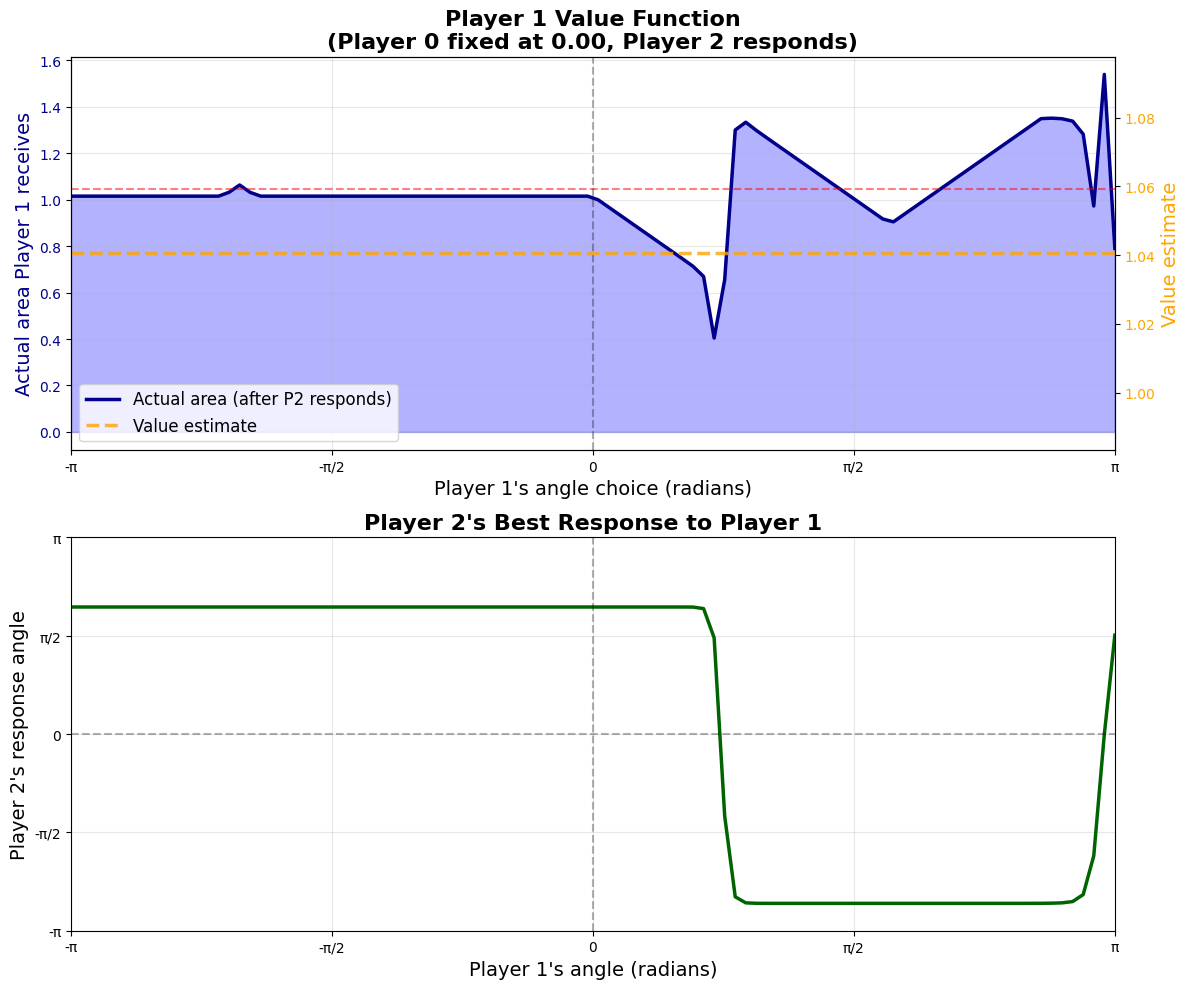

In [33]:


model = PPO.load('radii_agents_two_player.zip')
eval_env = TwoPlayerCakeCuttingEnv(policy=model, fixed_angle=0.0, noise_std=0.0)
fig = visualize_player1_value_function(model, fixed_angle=0.0)
fig.savefig('./player1_value_analysis.png', dpi=300, bbox_inches='tight')
plt.show()




Player 2 Value Function Analysis:
  At equilibrium (Player 1 = -2.1371): 0.9982
  Minimum value: 0.3625 at Player 1 angle = 0.9203
  Maximum value: 0.9987 at Player 1 angle = -2.1261
  Fair share (π/3): 1.0472


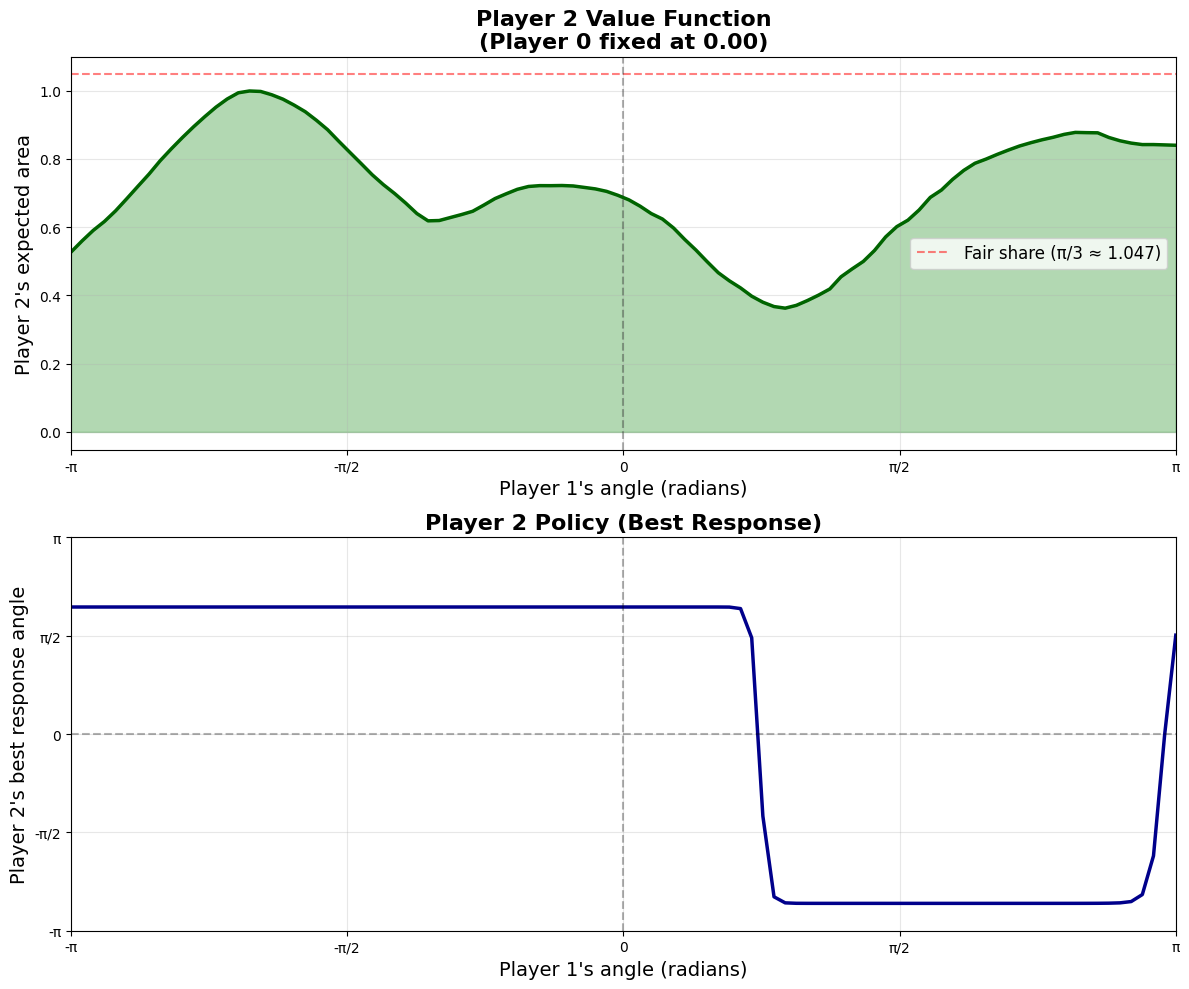

In [34]:
fig = visualize_player2_value_vs_player1_angle(model, fixed_angle=0.0)
fig.savefig('./player2_value_analysis.png', dpi=300, bbox_inches='tight')
plt.show()